In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

In [33]:
# LOAD DATA
rootdir = 'data/processed/'
# Load the binned Eulerian data
# Volume weighted mean temperature in upper 50m of NA as a function of density
filepath_eul = rootdir+'eulerian/orca025_NA-z50_votemper-by-vosigmantr.nc'
T_eul = xr.open_dataset(filepath_eul)
# Load the Lagrangian data
# Volume * temperature
varVT = 'iViT'
filepath_lag = rootdir+'lagrangian/D3_weights-'+varVT+'_bins-final_age-init_dens-init_t_subset-final_section-7.nc'
VT_lag = xr.open_dataset(filepath_lag)
# Volume
varV = 'init_volume'
filepath_lag = rootdir+'lagrangian/D3_weights-'+varV+'_bins-final_age-init_dens-init_t_subset-final_section-7.nc'
V_lag = xr.open_dataset(filepath_lag)
# Volume-weighted mean temperature
var = 'fT'
T_lag = VT_lag[varVT]/V_lag[varV]
T_lag.name=var

In [34]:
# PROCESS EULERIAN DATA
# Group data by years and take the mean
years = np.arange(1958,2017,1)
T_eul_byyear = T_eul.groupby_bins(T_eul.time_counter.dt.year,years).mean(dim='time_counter')
# Calculate annual anomaly
T_eul_anom = T_eul_byyear-T_eul_byyear.mean('year_bins')

In [35]:
# PROCESS LAGRANGIAN DATA
T_lag_mean = T_lag.where(~np.isnan(T_lag)).mean(dim='init_t_bin') # Calculate the mean for all initialization times
T_lag_anom = (T_lag.isel(init_t_bin=-1).squeeze() - T_lag_mean).rename( # Get the anomaly and rebrand coord as year
    {'final_age_bin':'final_year_bin'}).assign_coords(
    final_year_bin=np.flip(years[:-1]+years[1:])/2)

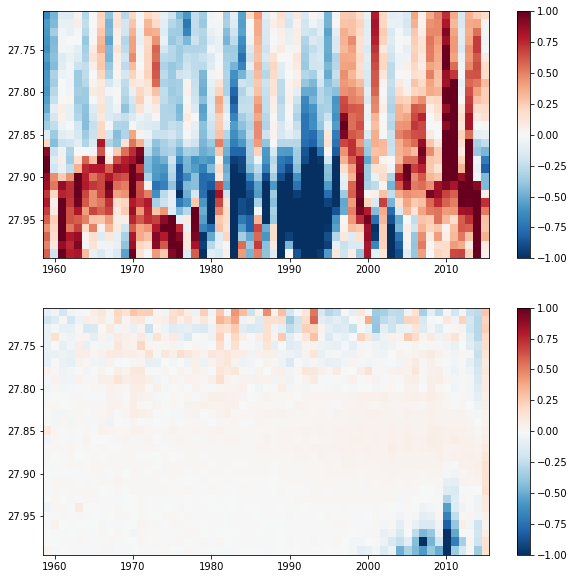

In [36]:
# PLOT
fig,ax = plt.subplots(figsize = (10,10),nrows = 2)
im = ax[0].pcolormesh(0.5*(years[:-1]+years[1:]),
                      T_eul_anom.vosigmantr_bin,
                      T_eul_anom.histogram_vosigmantr.transpose(),
                      vmin = -1, vmax = 1, cmap = 'RdBu_r')
ax[0].invert_yaxis()
plt.colorbar(im,ax=ax[0])

im = ax[1].pcolormesh(T_lag_anom.final_year_bin,
                      T_lag_anom.init_dens_bin,
                      T_lag_anom.transpose(),
                      vmin=-1,vmax=1,cmap='RdBu_r')
ax[1].invert_yaxis()
plt.colorbar(im,ax=ax[1])